In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Parameter-file generation
### Input: raw sequences (contigs.fasta)
### Input: annotation (annotation.gff3)

In [2]:
annotation_filename = "training_my_ghmm.gff" # "scaffolds.07-31.cleaned.gff"
sequence_filename = "scaffolds.fasta"
output_filename = "parameters.new.automatic.properties"

parameters = dict()
parameters["start_region_size"] = 6
parameters["stop_region_size"] = 24

### Output: parameters.properties

# Hyperparameters: To be chosen manually
 - `"ncs_flank_size"`: How many nt upstream of left and downstream of right end can be considered NCS?
 - `"ncs_mean_length"`: Manual estimate of how long an intergenic region is on average (in nt)

In [3]:
hyperparameters = {}
hyperparameters["ncs_flank_size"] = 300
hyperparameters["ncs_mean_length"] = 1000
hyperparameters["sds_size"] = 5
hyperparameters["sas_size"] = 4

hyperparameters["intron_length_tolerance"] = 4 # how far to extend beyond the seen range of intron lengths

In [4]:
# Gene format: CDS(begins with ATG) - intron - CDS - intron - CDS - stop_codon
# i.e.: CDS[starts with ATG] - {intron - CDS}* - stop_codon
# (thus, all genes have an even amount of features; start-codon is not treated separately)
# The annotation may however also contain other features, especially (for me): three_prime_UTR 
# -> when reading the file, replace this! (might also have to ignore some features)

complement = {"A": "T", "T": "A", "G": "C", "C": "G", "N": "N"}
base_order = "TCAG"
codon_list = [a + b + c for a in base_order for b in base_order for c in base_order]

rna_codon_list = [c.replace("T", "U") for c in codon_list]

def codon2index(codon):
    result = base_order.index(codon[0]) * 16
    result += base_order.index(codon[1]) * 4
    result += base_order.index(codon[2])
    return result

def positional_base_usage(fs):
    positional_fs = np.zeros((3, 4))
    for c in codon_list:
        for i in range(3): # position in codon
            positional_fs[i, base_order.index(c[i])] += fs[codon2index(c)]
    return positional_fs

# Simple approximation based on marginals
def fit_codon_usage(counts):
    positional_fs = positional_base_usage(counts)
    independent_codon_approximation = np.zeros(64)
    for c in codon_list:
        independent_codon_approximation[codon2index(c)] = np.product([positional_fs[i, 
                                                                                    base_order.index(c[i])] 
                                                                      for i in range(3)])
    
    return independent_codon_approximation

def rev_comp(sequence: str):
    result = ""
    for i in range(len(sequence)-1, -1, -1):
        result += complement[sequence[i]]
    return result

class Feature:
    def __init__(self, feature: str, start: int, end: int, strand: bool):
        self.start = start
        self.end = end
        self.strand = strand
        self.feature = feature
    
class Gene:
    def __init__(self, strand: bool):
        self.strand = strand
        self.features = [] # a sorted (!) list of CDS, introns and one UTR; sorted from 5' to 3', 
        # i.e. on reverse strand, the indices of subsequent features;
        # Sorting is trusted to the outside world; maybe check in isValid!
        
    def append(self, feature: Feature):
        self.features.append(feature)
        
    def __len__(self):
        return len(self.features)
    
    def __str__(self):
        return " ".join(["%s%s %s %s%s" % ("[" if f.strand else "<", 
                                           f.start, f.feature, f.end,
                                           ">" if f.strand else "]") 
                         for f in self.features])

    def get_range(self):
        return self.features[0].start, self.features[-1].end
    
    # sequence is nucleotide sequence from scaffolds.fasta
    # this produces the concatenated cds -- potentially complementarily reversed (if strand is negative)
    def get_contiguous_cds(self, sequence: str):
        cds = "".join([sequence[(f.start-1):f.end] for f in self.features if f.feature == "CDS"])
        if self.strand:
            return cds
        else:
            return rev_comp(cds)
        
    def codon_usage(self, sequence: str):
        cds = self.get_contiguous_cds(sequence)
        general = np.zeros(64)
        stop = np.zeros(64)
        general_n = 0
        for i in range(0, len(cds) - 21, 3):
            general[codon2index(cds[i:i+3])] += 1
            general_n += 1
            
        for i in range(len(cds) - 21, len(cds), 3):
            stop[codon2index(cds[i:i+3])] += 1
            
        print("term: %s : %s*UGA" % (cds[len(cds)-21:], stop[codon2index("TGA")]))
        return general, general_n, stop
        
    def count_UGA(self, sequence: str):
        inframe = 0
        outframe_in_cds = 0
        cds = self.get_contiguous_cds(sequence)
        for i in range(len(cds)-3):
            if sequence[i:i+3] == "TGA":
                if i % 3 == 0:
                    inframe += 1
                else:
                    outframe_in_cds += 1
        # REQUIRES this gene be valid
        # Pure sanity check
        if self.strand:
            stop = sequence[(self.features[-1].start-1):self.features[-1].end].count("TGA")
        else:
            stop = sequence[(self.features[0].start-1):self.features[0].end].count("TCA")
        
        
        return inframe, outframe_in_cds, stop
        
    def get_exon_intron_stats(self):
        """
        returns the 'exon'-lengths and intron-lengths found in this gene. The intron-lengths are exactly that, 
        but the exon-lengths are cleaned of everything that is not modeled by the CDS-state in the GHMM: 
        start-codon, stop-region, intron-flanking interrupted codons (which makes little difference, but still)
        """
        exon_lengths = []
        intron_lengths = []
        i = 0 # index of feature
        after_intron = 0 # how many bases of a codon come after the last intron (codon interrupted)
        
        for f in self.features:
            if f.feature == "CDS":
                length = f.end - f.start + 1 - after_intron # +1 bc. gff is inclusive-end
                if self.strand:
                    if i==0:
                        length -= 3 # cut off start-codon
                    elif i==len(self.features):
                        length -= parameters["stop_region_size"] - 3 # cut off stop-region, but not stop-codon
                else:
                    if i==0:
                        length -= parameters["stop_region_size"] - 3
                    elif i==len(self.features):
                        length -= 3 # cut off start-codon
                after_intron = (3 - (length % 3)) % 3 # from deviation from threevenness: get what needs to be cut off next
                length -= (3-after_intron) % 3 # cut off the part before the intron of the current exon
                exon_lengths += [length]
            elif f.feature == "intron":
                intron_lengths += [f.end - f.start + 1]
            i += 1
        
        return exon_lengths, intron_lengths
        
    def is_valid(self):
        if len(self.features) == 0:
            print("! The gene is empty")
            return False
        
        stop_index = -1 if self.strand else 0
        first_cds_index = 0 if self.strand else -1
        
        # a Gene must end in a stop_codon
        if self.features[stop_index].feature != "stop_codon":
            print("! 3' Terminal feature is not a stop_codon, but a %s" % self.features[stop_index].feature)
            return False
        # a Gene must start with a CDS
        if self.features[first_cds_index].feature != "CDS":
            print("! 5' terminal feature is not a CDS, but a %s" % self.features[first_cds_index].feature)
            return False
        
        # Gene must start with CDS, end with UTR (len >= 2 so far), and can have [intron, CDS]-pairs in between 
        # (no two cds adjacent, nor two introns)
        if len(self.features) % 2 != 0:
            print("! uneven number of features")
            return False
        
        num_stops = 0
        index = 0
        while index < len(self.features):
            if self.features[index].feature == "stop_codon":
                num_stops += 1
            if self.features[index+1].feature == "stop_codon":
                num_stops += 1
                
            if self.features[index].strand != self.strand or self.features[index+1].strand != self.strand:
                print("! Strand disagreement within the gene")
                return False
            
            if self.strand:
                if not (self.features[index].feature == "CDS" \
                        and self.features[index+1].feature in ["intron", "stop_codon"]):
                    print("! CDS-intron-CDS-stop_codon-pattern violated")
                    return False
            else:
                if not (self.features[index+1].feature == "CDS" \
                        and self.features[index].feature in ["intron", "stop_codon"]):
                    print("! CDS-intron-CDS-stop_codon-pattern violated")
                    return False
            
            index +=2
            
        if num_stops != 1:
            print("! Too many stops: %s" % num_stops)
            return False   
        
        return True

class Annotation:
    def __init__(self, name: str, start: int, end: int):
        self.name = name
        self.start = start
        self.end = end
        self.features = [] # The list of features; could also separate this by strand
        self.genes = []
    
    def add(self, feature: Feature):
        index = 0
        while index < len(self.features):
            if self.features[index].start > feature.end:
                self.features.insert(index, feature)
                return
            index += 1
        self.features.append(feature)
        
    def compile_genes(self) -> bool:
        all_valid = True
        self.genes = []
        last_end = self.features[0].start - 1
        current_gene = Gene(self.features[0].strand)
        for f in self.features:
            if f.start != last_end + 1: # there is a break
                self.genes.append(current_gene)
                all_valid = all_valid and current_gene.is_valid()
                current_gene = Gene(f.strand)
                
            current_gene.append(f)
            last_end = f.end
        
        if len(current_gene) > 0:
            self.genes.append(current_gene)
            all_valid = all_valid and current_gene.is_valid()
        
        return all_valid
        
        
    def __str__(self):
        return self.name + ":\n\t" + ("\n\t".join(["[%s, %s]%s%s" % (f.start, f.end,
                                                                     f.feature, 
                                                                     "+" if f.strand else "-") 
                                               for f in self.features]))
    
def format_matrix(matrix):
    return "{{%s}}" % "}\\\n  {".join([", ".join([str(e) for e in row]) for row in matrix])

# Input: Annotation

In [5]:
annotations = []
with open(annotation_filename) as annotation_file:
    c = 0
    f = 0
    line = annotation_file.readline()
    current = None
    while line:
        line = annotation_file.readline()[:-1]
        content = line.split("\t")
        if line.startswith("##sequence-region"):
            print(current)
            if current is not None:
                correct = current.compile_genes()
                if not correct:
                    f += 1
                print("+ valid gene structure" if correct else "/!\\ invalid gene structure")
                print("Genes:\n\t" + "\n\t".join([str(g) for g in current.genes]))
                annotations.append(current)
            print("-  " * 36)
            
            current = Annotation(content[1], int(content[2]), int(content[3]))
            c += 1
        elif len(line) > 0 and not line.startswith("#"):
            # Transform 3'UTR-annotation into stop-codons!
            feature = content[2]
            forward = content[6] == "+"
            start = int(content[3])
            end = int(content[4])
            if feature == "three_prime_UTR":
                if forward:
                    end = start+2
                else:
                    start = end-2
                feature = "stop_codon"
                
            current.add(Feature(feature, start, end, forward))

print(current.compile_genes())
print("Genes:\n\t" + "\n\t".join([str(g) for g in current.genes]))
annotations.append(current)
print(c, "=", len(annotations), "of which", f, "were faulty")

annotation_dict = {a.name:a for a in annotations}
num_of_genes = np.sum([len(a.genes) for a in annotations])
print("There are %s genes annotated" % num_of_genes)


# Get information that does not require sequences:
intron_lengths = []
exon_lengths = []
intron_counts = []
for ann in annotations:
    for gene in ann.genes:
        el, il = gene.get_exon_intron_stats()
        exon_lengths += el
        intron_lengths += il
        if (len(il) > 0 and np.max(il) > 30):
            print(ann.name, il)
            # Can see that the two largest ones (58, 85) are from 615, 
            # and are not very trusted (coverage-signal is ambiguous)
        intron_counts += [len(il)]

None
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
NODE_64_length_178741_cov_1.661034:
	[129866, 131170]CDS+
	[131171, 131173]stop_codon+
+ valid gene structure
Genes:
	[129866 CDS 131170> [131171 stop_codon 131173>
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
NODE_65_length_177181_cov_1.879014:
	[59358, 59360]stop_codon-
	[59361, 59484]CDS-
	[59485, 59501]intron-
	[59502, 60271]CDS-
+ valid gene structure
Genes:
	<59358 stop_codon 59360] <59361 CDS 59484] <59485 intron 59501] <59502 CDS 60271]
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
NODE_69_length_175562_cov_1.893300:
	[4520, 6490]CDS+
	[6491, 6493]stop_codon+
+ valid gene structure
Genes:
	[4520 CDS 6490> [6491 stop_codon 6493>
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
NODE_9

# Input: Raw sequences

In [6]:
counts = np.zeros((num_of_genes,3))
codon_usage_general = np.zeros(64)
codon_usage_stop = np.zeros(64)
codon_number = 0
stop_codon_number = 0

start_upstream = 3
start_regions = []
introns_by_length = {}
ncs_base_counts = np.zeros(4)

current_header = None
current_sequence = ""
gene_index = 0
with open(sequence_filename) as scaffolds:
    for row, line in enumerate(scaffolds):
        if line.startswith(">"):
            # Here query the analysis
            if current_header is not None:
                if current_header in annotation_dict:
                    print(current_header)
                    ann = annotation_dict[current_header]
                    for gene in ann.genes:
                        # Collect base-frequencies in flanking NCS
                        
                        start, end = gene.get_range()
                        ncs_left = current_sequence[max(0, start -1 -hyperparameters["ncs_flank_size"]): start]
                        ncs_right = current_sequence[end: min(end+hyperparameters["ncs_flank_size"], len(current_sequence))]
                        ncs = ncs_left + ncs_right
                        
                        for i in range(4):
                            ncs_base_counts[i] += ncs.count(base_order[i])
                        
                        # Collect number of inframe-stops, outframe-stops, and check for presence of stop as annotated
                        counts[gene_index, :] = np.array(gene.count_UGA(current_sequence))
                        print("\t", counts[gene_index,:])
                        if counts[gene_index,2] == 0:
                            print("\t\t\t\t!>!>!>missing STOP")
                            
                        # Collect codon usage in CDS and stop regions
                        cds_codon_counts, cds_num_of_codons, stop_region = gene.codon_usage(current_sequence)
                        codon_number += cds_num_of_codons
                        stop_codon_number += 7
                        codon_usage_general += cds_codon_counts
                        codon_usage_stop += stop_region
                        
                        gene_index += 1
                        
                        # Collect intron sequences:
                        for f in [f for f in gene.features if f.feature == "intron"]:
                            curr_intron = current_sequence[(f.start-1):f.end]
                            curr_intron_length = f.end - f.start + 1
                            if not f.strand:
                                curr_intron = rev_comp(curr_intron)
                            if curr_intron_length not in introns_by_length:
                                introns_by_length[curr_intron_length] = [curr_intron]
                            else:
                                introns_by_length[curr_intron_length] += [curr_intron]
                            
                            print("intron: ", curr_intron)
                            
                        # Collect start-region:
                        g_start, g_end = gene.get_range()
                        if gene.strand:
                            start_regions += [current_sequence[max(0, g_start-1-start_upstream):
                                                               min(len(current_sequence), g_start+2)]]
                        else:
                            start_regions += [rev_comp(current_sequence[max(0, g_end-3):
                                                                        min(len(current_sequence), g_end+start_upstream)])]
                        if not start_regions[-1].endswith("ATG"):
                            print("! weird Start-region", start_regions[-1], "\n")
            
            current_header = line[1:-1]
            current_sequence = ""
        else:
            current_sequence += line[:-1]

NODE_64_length_178741_cov_1.661034
	 [ 4. 12.  1.]
term: AGAGAATAGATGCTTTCCAAG : 0.0*UGA
NODE_65_length_177181_cov_1.879014
	 [9. 9. 1.]
term: TCAGTTGTTCCGTATTTCCTT : 0.0*UGA
intron:  GTAATTTCATTATGCAG
NODE_69_length_175562_cov_1.893300
	 [18. 17.  1.]
term: CTGTATTCAAGAGCTAGATTA : 0.0*UGA
NODE_90_length_157735_cov_1.661280
	 [2. 8. 1.]
term: CTCTATGAGCAGCTTAAGTGT : 0.0*UGA
NODE_103_length_148054_cov_1.718544
	 [ 6. 18.  1.]
term: ATTATGTAGTGGAAAAGAGCT : 0.0*UGA
intron:  GTAATATTTATTAATTTTAG
NODE_127_length_132101_cov_1.744328
	 [11. 18.  1.]
term: ATGGTCAATAAGCCCAAACAA : 0.0*UGA
intron:  GTAAATTTTAATTTTTAG
	 [18. 28.  1.]
term: TTTGGAAGAGGACTTATTGAT : 0.0*UGA
NODE_134_length_130250_cov_1.655841
	 [12. 16.  1.]
term: AATCCAGAATACCTTTTGCTC : 0.0*UGA
NODE_135_length_129955_cov_1.831608
	 [ 0. 10.  1.]
term: GCAAATTTAATCCCTCCTATT : 0.0*UGA
intron:  GTAAGCTTTTATATAG
NODE_150_length_122897_cov_1.750631
	 [ 7. 15.  1.]
term: GGAGCTGAAAATTTCCTAAGT : 0.0*UGA
NODE_155_length_121415_cov_1.724095

## NCS-parameters
 - Estimate NCS-base-frequency from flanking NCS
 - How estimate NCS-length? Have user specify mean NCS-length estimate (allowed to be manual), thence geometric estimate

In [7]:
parameters["base_frequencies_NCS"] = "{%s}" % ", ".join([str(f) for f in ncs_base_counts / np.sum(ncs_base_counts)])
parameters["transition_probability_of_staying_in_NCS"] = 1-1/hyperparameters["ncs_mean_length"]

## CDS-parameters
 - Estimate probability to stay in CDS by assuming geometric **distr. of cds/exon length** (mean)
 - Estimate probability of going to stop by assuming geometric model of **number of introns** (mean)
 - Compute empirical **positional base frequency marginals**
 - For Stop-region: compute empirical **codon usage** outside stop-regions
 
For the probability of staying in CDS (with mean length $\mu$ in nucleotides, thus mean length in codons $\frac{\mu}{3}$): $p_{leave} = \frac{1}{\frac{\mu}{3}} = \frac{3}{\mu}$ and thus $p_{stay} = 1-\frac{3}{\mu}$

In [8]:
print("There should not be any exon-length not divisible by three, and there are", 
      np.sum([l % 3 for l in exon_lengths]), "which are not divisible by 3")

parameters["transition_probability_of_staying_in_CDS"] = 1 - 3 / np.mean(exon_lengths)
parameters["transition_probability_of_CDS_to_stop_given_that_CDS_is_being_left"] = 1/(1+np.mean(intron_counts))

cds_positional_marginals = positional_base_usage(codon_usage_general / codon_number)

parameters["base_frequency_marginals_CDS"] = format_matrix(cds_positional_marginals)

There should not be any exon-length not divisible by three, and there are 0 which are not divisible by 3


## Start region parameters
These are difficult to infer automatically (especially the length of the pattern); can infer the base-probabilities

In [9]:
start_region_bases = np.zeros((start_upstream + 3, 4))
# print("\n".join(start_regions))
for r in [r for r in start_regions if len(r) == start_upstream + 3]:
    # print(r)
    for i in range(start_upstream + 3):
        start_region_bases[i, base_order.index(r[i])] += 1
        
actual_start_region = start_region_bases / num_of_genes
print("Sanity check: the last 3 rows should show deterministic ATG")
print(actual_start_region)
actual_start_region = np.mean(actual_start_region[:3,:], axis=0)
parameters["base_frequencies_start_region_upstream"] = "{%s}" % ", ".join([str(p) for p in actual_start_region])

Sanity check: the last 3 rows should show deterministic ATG
[[0.10344828 0.         0.89655172 0.        ]
 [0.12068966 0.         0.79310345 0.0862069 ]
 [0.18965517 0.         0.74137931 0.06896552]
 [0.         0.         1.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.         0.         1.        ]]


## Stop region parameters
Size is fixed; like for start-region, this has to be done manually (_could_ try some sort of automation, but likely not very good, and not worth the effort)
 - Compute empirical **positional base frequency marginals**
 - Compute empirical **codon usage** in and outside stop region
 - Force UGA to 0
 - Force UAA to empirical (low) frequency
 - Find the codon which maximises the difference between codon-wise $stopregion - cds$ and base-wise $stopregion - cds$ (cf `StopCodons.ipynb`) and correct its probability
 - Find a compensatory codon, and correct its probability (4 codons explicit)
 
The latter part can be extended: Could also pick the top 3 most devious codons, and then 2 compensatory ones etc.

In [10]:
empirical_codon_frequencies_stop = codon_usage_stop / stop_codon_number
empirical_codon_frequencies_general = codon_usage_general / codon_number

print("{%s}" % ", ".join([str(i) for i in empirical_codon_frequencies_stop]))

{0.027093596059113302, 0.027093596059113302, 0.03201970443349754, 0.022167487684729065, 0.019704433497536946, 0.007389162561576354, 0.014778325123152709, 0.0, 0.029556650246305417, 0.014778325123152709, 0.0, 0.017241379310344827, 0.0024630541871921183, 0.012315270935960592, 0.0, 0.017241379310344827, 0.034482758620689655, 0.012315270935960592, 0.024630541871921183, 0.0049261083743842365, 0.014778325123152709, 0.009852216748768473, 0.017241379310344827, 0.0024630541871921183, 0.0024630541871921183, 0.0049261083743842365, 0.027093596059113302, 0.007389162561576354, 0.0024630541871921183, 0.0024630541871921183, 0.0, 0.0, 0.03201970443349754, 0.017241379310344827, 0.019704433497536946, 0.027093596059113302, 0.022167487684729065, 0.0024630541871921183, 0.014778325123152709, 0.0, 0.027093596059113302, 0.022167487684729065, 0.05665024630541872, 0.03201970443349754, 0.007389162561576354, 0.0024630541871921183, 0.03940886699507389, 0.0049261083743842365, 0.029556650246305417, 0.0147783251231527

<IPython.core.display.Javascript object>


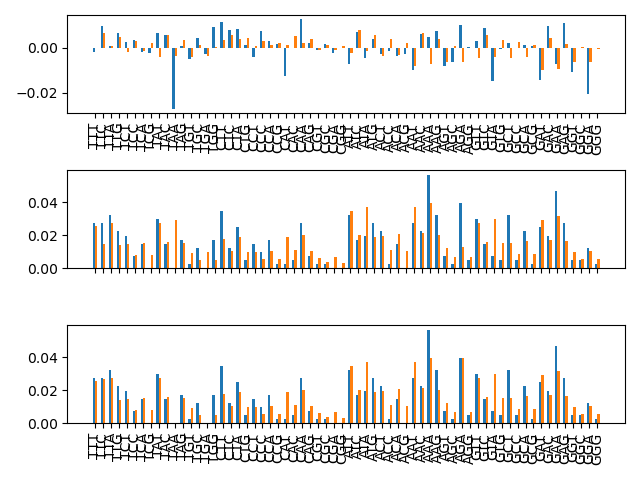

{TGA: 0, TAA: 0.0, AGA: 0.03940886699507389, TTC: 0.02691749925018771}
blue: empirical
orange: base-wise/approximate


In [11]:
stop_positional_marginals = positional_base_usage(codon_usage_stop / stop_codon_number)
parameters["base_frequency_marginals_stop_region"] = format_matrix(stop_positional_marginals)

def difference_of_approximation(empirical_close, empirical_far, approx_close, approx_far):
    return (empirical_close - empirical_far) - (approx_close - approx_far)

explicit = {"TGA": 0, "TAA": empirical_codon_frequencies_stop[codon2index("TAA")]}

# Finding another two codons to be included:
basewise_codon_frequencies_stop = fit_codon_usage(empirical_codon_frequencies_stop)
basewise_codon_frequencies_general = fit_codon_usage(empirical_codon_frequencies_general)

# Plot: which codons are the most informative w.r.t. stop vs general:
w = 0.3
plt.subplot(3,1,1)
plt.bar(np.arange(64)-w/2, empirical_codon_frequencies_stop - empirical_codon_frequencies_general, width=w)
plt.bar(np.arange(64)+w/2, basewise_codon_frequencies_stop - basewise_codon_frequencies_general, width=w)
plt.xticks(range(64), codon_list, rotation=90)

# Plot before:
plt.subplot(3,1,2)
plt.bar(np.arange(64)-w/2, empirical_codon_frequencies_stop, width=w)
plt.bar(np.arange(64)+w/2, basewise_codon_frequencies_stop, width=w)
plt.xticks(range(64), [""] * 64)

# Corrections:
diff = difference_of_approximation(empirical_codon_frequencies_stop, 
                                   empirical_codon_frequencies_general, 
                                   basewise_codon_frequencies_stop, 
                                   basewise_codon_frequencies_general)
diff[codon2index("TGA")] = 0
diff[codon2index("TAA")] = 0
abs_diff = np.absolute(diff)

most_prominent_deviant = codon_list[np.argmax(abs_diff)]
explicit[most_prominent_deviant] = empirical_codon_frequencies_stop[np.argmax(abs_diff)]
diff[np.argmax(abs_diff)] = 0

corrected_sum = 0
basewise_sum = 0
for codon in explicit:
    corrected_sum += explicit[codon]
    basewise_sum += basewise_codon_frequencies_stop[codon2index(codon)]
    # print("+", codon, corrected_sum, basewise_sum)
desired_deviation = basewise_sum - corrected_sum
# print(desired_deviation)

# Find compensator:
diff = empirical_codon_frequencies_stop - basewise_codon_frequencies_stop
candidates = sorted([c for c in codon_list if c not in ["TGA", "TAA", most_prominent_deviant]], 
                    key=lambda codon: abs(diff[codon2index(codon)] - desired_deviation))

explicit[candidates[0]] = empirical_codon_frequencies_stop[codon2index(candidates[0])]
corrected_sum = 0
basewise_sum = 0
for codon in explicit:
    corrected_sum += explicit[codon]
    basewise_sum += basewise_codon_frequencies_stop[codon2index(codon)]
    # print("+", codon, corrected_sum, basewise_sum)

explicit[candidates[0]] += basewise_sum - corrected_sum

parameters["explicit_codon_probabilities_stop_region"] = "{%s}" % ", ".join(["%s: %s" % (k, explicit[k]) 
                                                                             for k in explicit])
print(parameters["explicit_codon_probabilities_stop_region"])


plt.subplot(3,1,3)
plt.bar(np.arange(64)-w/2, empirical_codon_frequencies_stop, width=w)
plt.bar(np.arange(64)+w/2, [explicit[codon] if codon in explicit else basewise_codon_frequencies_stop[codon2index(codon)] 
                            for codon in codon_list], width=w)
plt.xticks(range(64), codon_list, rotation=90)

plt.tight_layout()
plt.show()

print("blue: empirical")
print("orange: base-wise/approximate")

## Intron parameters
 - collect **intron lengths**
 - Compute intron length median/mean (for breakpoint)
 - find min and max intron length; find 5% and 95% quantiles; extend from quantiles (subsequent AUGUSTUS can still concern itself with long introns)
 - Maybe derive a maximum-likelihood approach for inferring the parameters (would be good)
 - manually set SDS- and SAS-size? Or try sliding a categorical model fit to the intron-middle onto the edges, and stop where they deviate significantly?
 - collect **empirical base-frequencies at SDS, SAS, and in between**
 
 - **For Poisson** only need the mean (+ min and max for truncation)

In [12]:
# TODO: remove the unreliable annotation with the big introns!
intron_lengths = [l for l in intron_lengths if l < 40]
print("intron lengths:", np.min(intron_lengths), np.mean(intron_lengths), np.max(intron_lengths))
print(np.mean(intron_counts))

parameters["intron_minimum_length"] = np.min(intron_lengths) - hyperparameters["intron_length_tolerance"]
parameters["intron_maximum_length"] = np.max(intron_lengths) + hyperparameters["intron_length_tolerance"]
parameters["intron_mean_length"] = np.mean(intron_lengths)

# # v # SEQUENCE information # v # #

sds_frequencies = np.zeros((hyperparameters["sds_size"], 4))
sas_frequencies = np.zeros((hyperparameters["sas_size"], 4))
intron_base_frequencies = np.zeros(4)

# ADD PSEUDOCOUNTS!
sds_frequencies[2:,:] = 1
sas_frequencies[:-2,:] = 1

for l in introns_by_length:
    for intron in introns_by_length[l]:
        sds = intron[:hyperparameters["sds_size"]]
        for i in range(len(sds)):
            sds_frequencies[i, base_order.index(sds[i])] += 1
        
        middle = intron[hyperparameters["sds_size"]:-hyperparameters["sas_size"]]
        for i in range(len(middle)):
            intron_base_frequencies[base_order.index(middle[i])] += 1
            
        sas = intron[-hyperparameters["sas_size"]:]
        for i in range(len(sas)):
            sas_frequencies[i, base_order.index(sas[i])] += 1
        # print("%s %s %s" % (sds, middle, sas))
        
parameters["intron_base_frequencies_splice_donor_site"] = format_matrix((sds_frequencies.T / np.sum(sds_frequencies, 
                                                                                                    axis=1)).T)
parameters["intron_base_frequencies_splice_acceptor_site"] = format_matrix((sas_frequencies.T / np.sum(sas_frequencies, 
                                                                                                       axis=1)).T)
parameters["intron_base_frequencies"] = "{%s}" % ", ".join([str(f) 
                                                            for f 
                                                            in intron_base_frequencies / np.sum(intron_base_frequencies)])


intron lengths: 16 17.806451612903224 26
0.5344827586206896


# Writing the parameters

In [13]:
with open(output_filename, "w") as out:
    result = "# automatically generated parameter file\n"
    result += "# from annotation file: " + annotation_filename + "\n"
    result += "# and sequence file: " + sequence_filename + "\n"
    result += "### Hyperparameters: \n"
    for key in hyperparameters:
        result += "# %s: %s\n" % (key, hyperparameters[key])
    
    for key in parameters:
        result += "%s: %s" % (key, parameters[key])
        result += "\n"
    
    out.write(result)